# Predictive Analysis

Analysis was performed on an **Amazon EC2** instance running the latest anaconda packages (as of Nov. 2018) and Python 3.7.

All data was imported from **Amazon S3 Buckets**

To stay within the free tier provided by Amazon, a limited test set of 10,000 randomly chosen samples was utilized. The memory limitation could be overcome by utilizing a scaling option within the EC2 instance.

The following analysis shows that additional feature engineering is required. Most noteably:
- All available data should be utilized in future analysis to aquire the most predictive model possible
- MLS Real Estate data should be made available for training the model
    - Features that included number of rooms and housing size (area) would drastically improve the model
    - We can see from datasets such as the [Boston Housing](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) dataset, that these are powerful features for value prediction.
- Training the data on a previous year's data should be tested on the current year's data to see the relevance of predicting annual data from the model 

# Dummy Variables

Utilizing dummy variables for `zoning`, `garage`, and `neighbourhood` resulted in very high dimensionality and decreased scoring results.

### Alternative approach

The `garage` feature was simply converted to an integer, the `zoning` feature was converted to an integer utilizing a dictionary and the `map()` method, and the `neighbourhood` was left in its integer ID form.

This approach results in marginally better scoring for all learners.

# After Feature Engineering

After the feature set is complete, the Random Forest Regressor performs marginally better than the ExtraTreesRegressor and significantly better than a simple Linear Regressor. Resulting in a mean error of \$96,985.34

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib

In [2]:
ml = pd.read_csv('https://s3-us-west-2.amazonaws.com/schellenbergers3bucket/property_assess_1')

In [3]:
ml.garage = ml.garage.astype(int)

In [4]:
zones_map = {'RF1':1, 'RF4':2, 'RSL':3, 'RF5':4, 'RA7':5, 'RPL':6, 'RF6':7, 'RMD':8, 'RF3':9,\
       'RA8':10, 'RR':11, 'RA9':12, 'UCRH':13, 'RF2':14, 'RA8h':15, 'RMH':16, 'RA7a':17, 'TSLR':18,\
       'RF4t':19, 'RPLt':20, 'RF5t':21, 'RA7*':22, 'TSDR':23, 'RA9*':24, 'RF6*':25, 'HDR':26,\
       'RMU':27, 'CR':28, 'RF5g':29, 'RA7g':30, 'EETR':31}

ml.zoning = ml.zoning.map(zones_map)
ml.head()

,value,nb_id,garage,zoning,lot_size,year_built,crime_per_capita
0,312500,6350.0,1,1,557.0,1964.0,0.012926
1,388500,6350.0,1,1,566.0,1962.0,0.012926
2,554500,6350.0,1,2,886.0,1968.0,0.012926
3,421500,6350.0,1,1,580.0,1962.0,0.012926
4,413000,6350.0,1,1,554.0,1965.0,0.012926


In [5]:
X = ml.drop('value', axis=1).values
y = ml['value'].values

In [6]:
y.reshape(-1,1)

array([[312500],
       [388500],
       [554500],
       ...,
       [408500],
       [455500],
       [446000]])

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [9]:
# Setup the pipeline steps: steps
steps = [('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('rfr', ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None, max_leaf_nodes=None, 
                                     max_features='auto', min_impurity_decrease=0.0, min_impurity_split=None, 
                                     min_samples_leaf=1, min_samples_split=2, 
                                     min_weight_fraction_leaf=0.0, n_jobs=-1, 
                                     oob_score=False, random_state=123, verbose=False, warm_start=False))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators':(1, 121)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: yeg_cv
yeg_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)

# Fit to the training set
yeg_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv.best_params_))
print("Tuned RandomForest Mean Squared Error: {}".format(mse))
print('Mean Error:', np.sqrt(abs(mse)))

Tuned RandomForest estimators: {'rfr__n_estimators': 121}
Tuned RandomForest Mean Squared Error: -9466886446.89646
Mean Error: 97297.92622094501


In [10]:
for i in [1, 10, 100, 1000, 10000, 100000]:
    print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[i])), 'actual value:', np.atleast_2d(y_test[i]))

predicted value: [371959.36639118] actual value: [[323000]]
predicted value: [194111.61645086] actual value: [[214000]]
predicted value: [378669.4214876] actual value: [[388500]]
predicted value: [995865.90909091] actual value: [[807000]]
predicted value: [215529.20960726] actual value: [[220000]]
predicted value: [136244.7939639] actual value: [[100500]]


In [11]:
x_axis = yeg_cv.predict(X_test)
y_axis = y_test

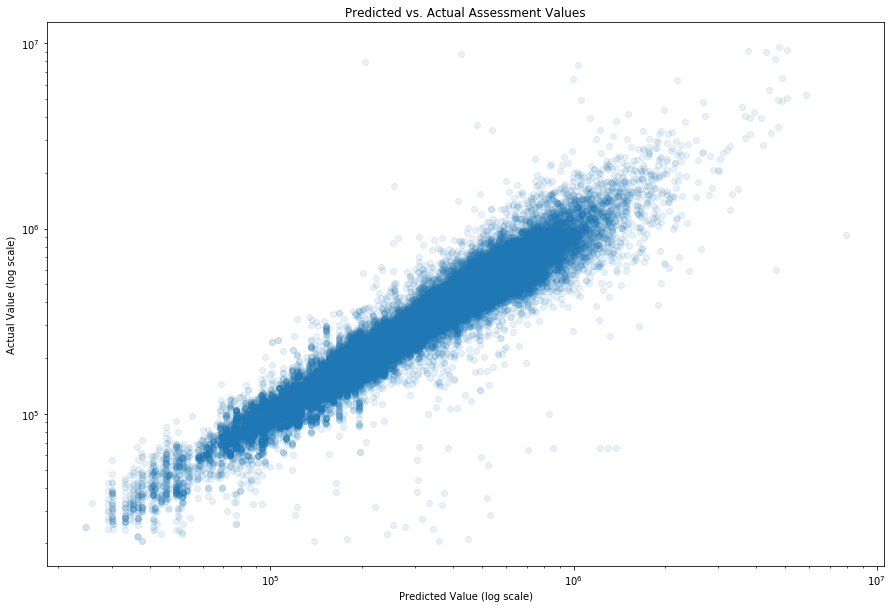

In [12]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_axis, y_axis, alpha=0.1)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [13]:
joblib.dump(yeg_cv, 'LowFeatXtraTrees.joblib')

['LowFeatXtraTrees.joblib']

# Best Performing Learner:

# Random Forest Regressor

In [8]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler()),
         ('rfr', RandomForestRegressor(max_depth=20))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators':(10,100)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: gm_cv
yeg_cv_reg = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error')

# Fit to the training set
yeg_cv_reg.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv_reg.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv_reg.best_params_))
print("Tuned RandomForest mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in ve

Tuned RandomForest estimators: {'rfr__n_estimators': 100}
Tuned RandomForest mean squared error: -9043215330.779953
95095.82183660833


In [9]:
joblib.dump(yeg_cv_reg, 'RandomForestReg.joblib')

['RandomForestReg.joblib']

In [17]:
x_axis = yeg_cv.predict(X_test)
y_axis = y_test

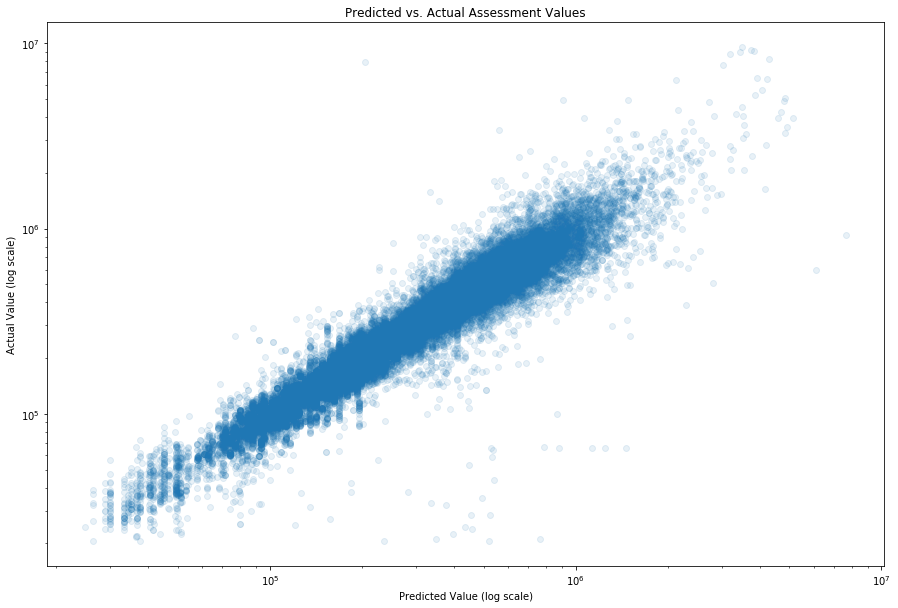

In [18]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_axis, y_axis, alpha=0.1)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

# Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

In [28]:
# Setup the pipeline steps: steps
steps = [('imputation', SimpleImputer(missing_values=np.nan)),
         ('scaler', StandardScaler()),
         ('reg', LinearRegression())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'imputation__strategy':('most_frequent','mean')}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: gm_cv
yeg_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)

# Fit to the training set
yeg_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv.score(X_test, y_test)
print("Tuned Imputer Parameters: {}".format(yeg_cv.best_params_))
print("Tuned Linear Regression mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

Tuned Imputer Parameters: {'imputation__strategy': 'most_frequent'}
Tuned Linear Regression mean squared error: -37057611485.52414
192503.53629355523


In [29]:
x_axis = yeg_cv.predict(X_test)
y_axis = y_test

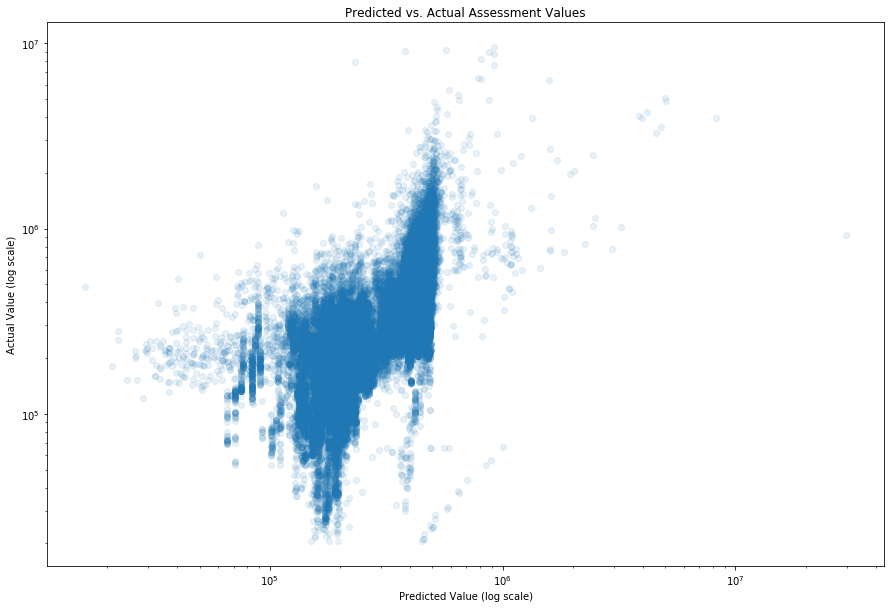

In [30]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_axis, y_axis, alpha=0.1)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()